In [3]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon.data import DataLoader, ArrayDataset
import numpy as np
import matplotlib.pyplot as plt
data_ctx = mx.cpu()
model_ctx = mx.cpu()


In [4]:
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)

In [5]:
#get the MNIST dataset
mnist_train = gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = gluon.data.vision.MNIST(train=False, transform=transform)

In [6]:
image,label = mnist_train[0]
print(image.shape, label)
help(mnist_train)

(28, 28, 1) 5.0
Help on MNIST in module mxnet.gluon.data.vision.datasets object:

class MNIST(mxnet.gluon.data.dataset._DownloadedDataset)
 |  MNIST handwritten digits dataset from http://yann.lecun.com/exdb/mnist
 |  
 |  Each sample is an image (in 3D NDArray) with shape (28, 28, 1).
 |  
 |  Parameters
 |  ----------
 |  root : str, default $MXNET_HOME/datasets/mnist
 |      Path to temp folder for storing data.
 |  train : bool, default True
 |      Whether to load the training or testing set.
 |  transform : function, default None
 |      A user defined callback that transforms each sample. For example::
 |  
 |          transform=lambda data, label: (data.astype(np.float32)/255, label)
 |  
 |  Method resolution order:
 |      MNIST
 |      mxnet.gluon.data.dataset._DownloadedDataset
 |      mxnet.gluon.data.dataset.Dataset
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, root='/Users/nguyen/.mxnet/datasets/mnist', train=True, transform=None)
 |     

784
10
60000
(28, 28, 3)


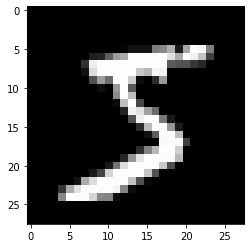

In [7]:
n_inputs = image.shape[0] * image.shape[1]
n_outputs =  10
n_examples = len(mnist_train)

print(n_inputs)
print(n_outputs)
print(n_examples)

#Transform the image to correct shape to use pyplot
im = mx.nd.tile(image, (1,1,3))
print(im.shape)
plt.imshow(im.asnumpy())
plt.show()

In [36]:
def softmax(z):
    exp = nd.exp(z - nd.max(z, axis=1).reshape((-1,1)))
    norm = nd.sum(exp, axis=1).reshape((-1,1))
    return exp/norm

def net(x):
    ypred = nd.dot(x, W) + b
    yhat = softmax(ypred)
    return yhat

def cross_entropy(yhat, y):
    return -nd.sum(y*nd.log(yhat+1e-6))


def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad


In [40]:
batch_size = 64

train_dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

W = nd.random.normal(shape=(n_inputs, n_outputs), ctx=model_ctx)
b = nd.random.normal(shape=n_outputs, ctx=model_ctx)

params = [W,b]

for param in params:
    param.attach_grad()
    
sample_y = nd.random.normal(shape=(2,10))

sample_yhat = softmax(sample_y)
print(sample_y)

print(sample_yhat)
print(nd.sum(sample_yhat, axis=1))



[[-1.7959518   1.3836894   0.27197918 -0.15085384  0.8824911  -0.9173083
  -0.38282967 -1.4841262  -0.4451735  -2.0375571 ]
 [-1.6115125   0.4244045   1.0231789  -0.31193107  0.11362571 -0.33210364
  -0.36815634  0.7795745  -0.18026796  0.7852503 ]]
<NDArray 2x10 @cpu(0)>

[[0.01533305 0.3685778  0.12126055 0.07944846 0.22328602 0.03691633
  0.06299987 0.02094367 0.05919215 0.01204206]
 [0.01537565 0.1177663  0.21432135 0.05639421 0.08630808 0.055268
  0.05331093 0.16798456 0.06433023 0.16894072]]
<NDArray 2x10 @cpu(0)>

[1. 1.]
<NDArray 2 @cpu(0)>


In [26]:
def evaluate_accuracy(dataloader, net):
    numerator = 0
    denominator = 0
    for i,(data, label) in enumerate(dataloader):
        data = data.as_in_context(mx.cpu()).reshape(-1,n_inputs)
        label = label.as_in_context(mx.cpu())
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

In [35]:
#Execute training loop
epochs = 5
learning_rate = .005

for e in range(epochs):
    cum_loss = 0
    for i, (data, label) in enumerate(train_dataloader):
        data = data.as_in_context(mx.cpu()).reshape(-1, n_inputs)
        label = label.as_in_context(mx.cpu())
        label_one_hot = nd.one_hot(label, 10)
        
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        
        SGD(params, learning_rate)
        cum_loss += nd.sum(loss).asscalar()
    
    test_acc = evaluate_accuracy(test_dataloader, net)
    train_acc = evaluate_accuracy(train_dataloader, net)
    
    print("Test acc: {} / Training acc: {}".format(test_acc, train_acc))

Test acc: 0.8616999983787537 / Training acc: 0.8574000000953674
Test acc: 0.883899986743927 / Training acc: 0.8826833367347717
Test acc: 0.8921999931335449 / Training acc: 0.8931166529655457
Test acc: 0.8992000222206116 / Training acc: 0.9002333283424377
Test acc: 0.9004999995231628 / Training acc: 0.9046499729156494


In [52]:
def model_predict(data, net):
    return nd.argmax(net(data), axis=1)

def visualize_data(net):
    sample_data = DataLoader(mnist_test, 10, shuffle=True)

    for i,(data, label) in enumerate(sample_data):
        data = data.as_in_context(mx.cpu())
        print(data.shape)

        im = nd.transpose(data,(1,0,2,3))
        im = nd.reshape(im,(28,10*28,1))
        imtiles = nd.tile(im, (1,1,3))

        plt.imshow(imtiles.asnumpy())
        plt.show()

        pred = model_predict(data.reshape(-1,n_inputs), net)
        print("Prediction : {}".format(pred))

        if i>10:
            break

Test acc : 0.8087 Train acc: 0.7962
Test acc : 0.8486 Train acc: 0.8391833333333333
Test acc : 0.8604 Train acc: 0.8552
Test acc : 0.8732 Train acc: 0.866
Test acc : 0.8782 Train acc: 0.8740666666666667
Test acc : 0.882 Train acc: 0.8798666666666667
Test acc : 0.8873 Train acc: 0.88445
Test acc : 0.8895 Train acc: 0.8882
Test acc : 0.8916 Train acc: 0.8901833333333333
Test acc : 0.8941 Train acc: 0.8935833333333333
(10, 28, 28, 1)


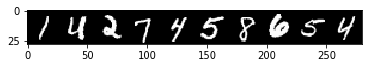

Prediction : 
[1. 4. 2. 7. 4. 5. 8. 6. 5. 4.]
<NDArray 10 @cpu(0)>
(10, 28, 28, 1)


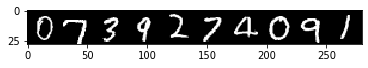

Prediction : 
[0. 7. 7. 9. 2. 7. 2. 0. 9. 1.]
<NDArray 10 @cpu(0)>
(10, 28, 28, 1)


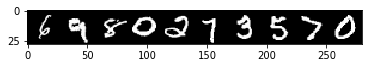

Prediction : 
[6. 9. 8. 0. 2. 7. 3. 5. 7. 0.]
<NDArray 10 @cpu(0)>
(10, 28, 28, 1)


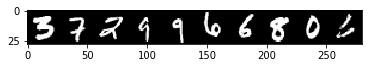

Prediction : 
[3. 7. 2. 9. 9. 6. 6. 8. 0. 5.]
<NDArray 10 @cpu(0)>
(10, 28, 28, 1)


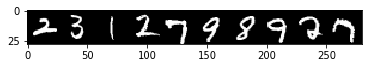

Prediction : 
[2. 3. 1. 2. 7. 9. 8. 9. 2. 7.]
<NDArray 10 @cpu(0)>
(10, 28, 28, 1)


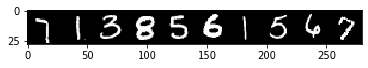

Prediction : 
[7. 1. 3. 8. 5. 6. 1. 5. 4. 7.]
<NDArray 10 @cpu(0)>
(10, 28, 28, 1)


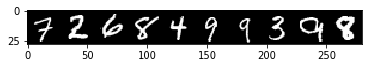

Prediction : 
[9. 2. 6. 8. 4. 9. 9. 3. 9. 8.]
<NDArray 10 @cpu(0)>
(10, 28, 28, 1)


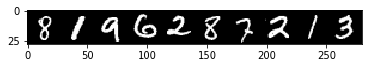

Prediction : 
[8. 1. 9. 6. 2. 8. 7. 2. 1. 3.]
<NDArray 10 @cpu(0)>
(10, 28, 28, 1)


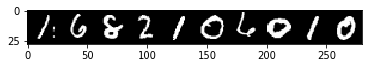

Prediction : 
[2. 6. 6. 2. 1. 0. 6. 0. 1. 0.]
<NDArray 10 @cpu(0)>
(10, 28, 28, 1)


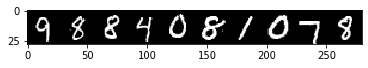

Prediction : 
[9. 8. 8. 5. 0. 8. 1. 0. 7. 8.]
<NDArray 10 @cpu(0)>
(10, 28, 28, 1)


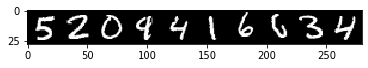

Prediction : 
[5. 2. 0. 4. 4. 1. 6. 6. 3. 4.]
<NDArray 10 @cpu(0)>
(10, 28, 28, 1)


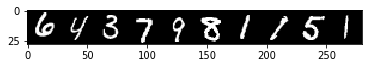

Prediction : 
[6. 4. 3. 7. 9. 8. 1. 1. 5. 1.]
<NDArray 10 @cpu(0)>


In [53]:
#build with Gluon
batch_size = 64
n_inputs = 784 # 28x28 image
n_outputs = 10 # 10 classes
n_examples = 60000

#define  context
ctx = mx.cpu()
#ctx = mx.gpu()

#define a net
net = gluon.nn.Dense(n_outputs)

#init params
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=ctx)

#loss function: SoftmaxCrossEntropyLoss
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

#optimizer with SGD
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.1})

#evaluate using mx.Accuracy
def evaluate_acc(data_iterator, net):
    acc = mx.metric.Accuracy()
    
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,n_inputs))
        label = label.as_in_context(ctx)
        
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels = label)
    return acc.get()[1]

#execute training loop

epochs = 10
moving_loss = 0

for e in range(epochs):
    cum_loss = 0
    for i, (data,label) in enumerate(train_dataloader):
        data= data.as_in_context(ctx).reshape((-1,n_inputs))
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        cum_loss+=nd.sum(loss).asscalar()
        
    test_acc = evaluate_acc(test_dataloader,net)
    train_acc = evaluate_acc(train_dataloader,net)
    
    print("Test acc : {} Train acc: {}".format(test_acc, train_acc))

#visualize results
visualize_data(net)
